Figure 4A: Correlation of controllability metrics (AC/MC) with node-wise control energy,
mean over participants.

d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
100%|██████████| 10/10 [00:07<00:00,  1.41it/s]
C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_7144\1271438712.py:43: RuntimeWarning: divide by zero encountered in arctanh
  fisher = np.arctanh(correls)


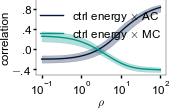

In [1]:
from ctrl.discrete_optimal_control2 import LQR
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ctrl import utils
from tqdm import tqdm
import custom_rcparams_paper as crc

data = utils.load_data(3)
N = len(data)
n_feat = data[0]['X'].shape[1]

r_space = np.logspace(-1, 2, 50)
n_r = len(r_space)

ctrl_energies = np.zeros((n_r, N, n_feat))
ac = np.zeros((N, n_feat))
mc = np.zeros((N, n_feat))

B = np.eye(n_feat)
C = np.eye(n_feat)
Q = np.eye(n_feat)

for j in tqdm(range(len(data))):     

    A = data[j]['A']  
    # B = data[j]['C']
    if not LQR.controllable(A, B):
        print(f'system {j} not controllable')
    ac[j] = LQR.average_ctrb(A, 15)
    mc[j] = LQR.modal_ctrb(A)
    X = data[j]['X']
    Yref = np.ones_like(X) * (-3)

    for r in range(n_r):
        R = np.eye(B.shape[1]) * r_space[r]
        U_opt = LQR.tracking_optimal_control(A, B, C, Q, R, X, Yref)
        ctrl_energies[r,j] = ((U_opt @ B.T) **2).mean(axis=0)
            
correls = np.array([[np.corrcoef((ctrl_energies[r, j], ac[j], mc[j])) 
                                 for j in range(len(data))] for r in range(n_r)])
fisher = np.arctanh(correls)
mean_correl_ac = fisher[:, :, 0, 1].mean(axis=1)
sem_correl_ac = stats.sem(fisher[:, :, 0, 1], axis=1)
mean_correl_mc = fisher[:, :, 0, 2].mean(axis=1)
sem_correl_mc = stats.sem(fisher[:, :, 0, 2], axis=1)
mean_energy = np.mean(np.sum(ctrl_energies, axis=2), axis=1)
sem_energy = stats.sem(np.sum(ctrl_energies, axis=2), axis=1)
legend_labels = [r'ctrl energy $\times$ AC', r'ctrl energy $\times$ MC']

fig, ax = plt.subplots(layout='constrained')
line_ac,  = ax.plot(r_space, np.tanh(mean_correl_ac), color=crc.colors.ac)
ax.fill_between(r_space, np.tanh(mean_correl_ac-sem_correl_ac), np.tanh(mean_correl_ac+sem_correl_ac),
                color=crc.colors.ac, alpha=0.3)

line_mc, = ax.plot(r_space, np.tanh(mean_correl_mc), color=crc.colors.mc)
ax.fill_between(r_space, np.tanh(mean_correl_mc-sem_correl_mc), np.tanh(mean_correl_mc+sem_correl_mc),
                color=crc.colors.mc, alpha=0.3)
ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10, 100))
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('correlation')
ax.set_ylim((-0.5, 1))
ax.set_yticks((-0.4, 0, 0.4, 0.8))
ax.set_yticklabels((r'$-$.4', r'.0', r'.4', r'.8'))

# ax2 = ax.twinx()
# line_e, = ax2.plot(r_space, mean_energy, color=crc.colors.energy)
# handles.append(line_e)
# ax2.fill_between(r_space, mean_energy-sem_energy, mean_energy+sem_energy, color=crc.colors.energy, alpha=0.3)
# ax2.set_ylabel('energy')
# ax2.set_ylim((-1, 80))
# ax2.set_yticks((0, 30, 60))

fig.legend((line_ac, line_mc), legend_labels)

fig.savefig('figures/paper/figure4A.png')
fig.savefig('figures/paper/figure4A.svg')
plt.show()

Figure 4B: Loss of the Trajectory (a.k.a. x.T @ Q @ x) given the optimal control strategy
and varying r, so that the Control loss in the total loss function has different impact.

100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


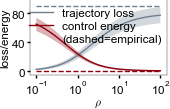

90.1549385656506 11.115213754885032
0.3032624425562523 [0.0325324  0.06845003 0.05185544 0.08546181 0.05767438 0.14639549
 0.16285692 0.1214674  0.19359769 0.30294477 0.26861937 0.04374534
 0.06972331 0.10581109 0.18377151]


In [2]:
from tqdm import tqdm
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from ctrl.discrete_optimal_control2 import LQR
from ctrl import utils
import custom_rcparams_paper as crc

data = utils.load_data(3)
N = len(data)
n_feat = data[0]['X'].shape[1]
r_space = np.logspace(-1, 2, 50)
n_r = len(r_space)
traj_losses = np.zeros((n_r, N))
emp_traj_losses = np.zeros((N))
ctrl_energies = np.zeros((n_r, N, n_feat))
emp_ctrl_energies = np.zeros((N, n_feat))
B = np.eye(n_feat)
C = np.eye(n_feat)
Q = np.eye(n_feat)
R = np.eye(B.shape[1])

for j in tqdm(range(len(data))):  

    A = data[j]['A']
    X = data[j]['X']
    Yref = np.ones_like(X) * (-3)
    for r in range(n_r):
        U_opt = LQR.tracking_optimal_control(A, B, C, Q, R*r_space[r], X, Yref)
        X_controlled = LQR.step(A, B, X, U_opt)
        traj_losses[r, j] = LQR.seminorm(Q, (X_controlled - Yref).T).mean()
        ctrl_energies[r,j] = ((U_opt @ B.T) **2).mean(axis=0)
    emp_traj_losses[j] = ((X-Yref)**2).sum(axis=1).mean()#LQR.seminorm(Q, (X - Yref).T).mean() #
    emp_ctrl_energies[j] = ((data[j]['Inp'] @ data[j]['C'].T)**2).mean(axis=0)

mean_traj = traj_losses.mean(axis=1)
sem_traj = stats.sem(traj_losses, axis=1)
mean_energy = np.mean(np.sum(ctrl_energies, axis=2), axis=1)
sem_energy = stats.sem(np.sum(ctrl_energies, axis=2), axis=1)

fig, ax = plt.subplots(layout='constrained')
handles = []
line_t,  = ax.plot(r_space, mean_traj)
ax.fill_between(r_space, (mean_traj-sem_traj), (mean_traj+sem_traj),
                alpha=0.3)
line_e, = ax.plot(r_space, mean_energy, color=crc.colors.energy)
ax.fill_between(r_space, mean_energy-sem_energy, mean_energy+sem_energy, color=crc.colors.energy, alpha=0.3)
line_emp_t, = ax.plot(r_space, [emp_traj_losses.mean()]*n_r, linestyle='--')
line_emp_e, = ax.plot(r_space, [emp_ctrl_energies.mean()]*n_r, linestyle='--', color=crc.colors.energy)
ax.set_ylim((-5,  100))
ax.set_ylabel('loss/energy')
ax.set_yticks((0, 40, 80))
ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10, 100))
ax.set_xlabel(r'$\rho$')
empty_line, = ax.plot([0,0],[0,0],linestyle='none',marker='none')
fig.legend((line_t, line_e, empty_line), ['trajectory loss', 'control energy', '(dashed=empirical)'])

plt.savefig('figures/paper/figure4B.png')
plt.savefig('figures/paper/figure4B.svg')
plt.show()

print(emp_traj_losses.mean(), stats.sem(emp_traj_losses))
print(emp_ctrl_energies.mean(), stats.sem(emp_ctrl_energies))

Figure 4C: Example control policies of participants with high and low r on max AC/MC node

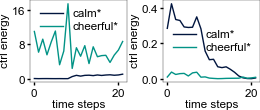

In [3]:
from ctrl.discrete_optimal_control2 import LQR
from ctrl import utils
import custom_rcparams_paper as crc
import numpy as np
import matplotlib.pyplot as plt

participants = [5]

for p in participants:

    data = utils.load_data(3)[p]
    A = data['A']
    X = data['X']
    features = data['Xlabs']
    n_feat = A.shape[0]
    B = np.eye(n_feat)
    C = np.eye(n_feat)
    Q = np.eye(n_feat)
    r_space = [0.1, 100]
    Rsmall = np.eye(n_feat) * r_space[0]
    Rlarge = np.eye(n_feat) * r_space[1]
    Yref = np.ones_like(X) * (-3)
    U = np.array([LQR.tracking_optimal_control(A, B, C, Q, Rsmall, X, Yref),
                LQR.tracking_optimal_control(A, B, C, Q, Rlarge, X, Yref)])

    ac = LQR.average_ctrb(A)
    mc = LQR.modal_ctrb(A)
    order_ac = np.argsort(ac)
    order_mc = np.argsort(mc)

    fig, axes = plt.subplots(1, 2, figsize=(2.6,1.1), layout='none')
    for r, title, ax in zip(range(len(r_space)), 
                            [rf'Low control constraint ($\rho={r_space[0]}$)', 
                            fr'High control constraint  ($\rho={r_space[1]}$)'], 
                            axes):
        ax.plot(U[r, :, order_ac[-1]]**2, color=crc.colors.ac)
        ax.plot(U[r, :, order_mc[-1]]**2, color=crc.colors.mc)
        ax.set_ylabel('ctrl energy')
        ax.set_xlabel('time steps')
        ax.legend([f'{features[order_ac[-1]]}',
                   f'{features[order_mc[-1]]}'])
    axes[0].set_yticks([0,8,16])
    axes[1].set_yticks([0,0.2,0.4])
    fig.savefig(f'figures/paper/figure4C_participant_{p}.png')
    fig.savefig(f'figures/paper/figure4C_participant_{p}.svg')
    plt.show()


Figure 4D: Share of control energy on the node with highest AC and MC

Figure 4E: Sample mean control energy for every node sorted by AC and MC

r=0.1: T=-2.9140074873826096, p=0.017198709547351625, df=9, alternative=less
r=0.1: T=-2.9140074873826096, p=0.9914006452263242, df=9, alternative=greater
r=100: T=6.139054771765596, p=0.00017096557685694234, df=9, alternative=less
r=100: T=6.139054771765596, p=8.548278842847117e-05, df=9, alternative=greater


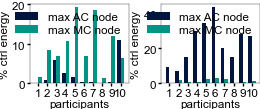

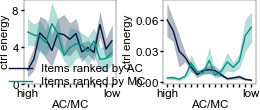

In [4]:
from ctrl.discrete_optimal_control2 import LQR
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from ctrl import utils

import custom_rcparams_paper as crc

data = utils.load_data(3)
N = len(data)
n_feat = data[0]['X'].shape[1]

r_space = [0.1, 100]
n_r = len(r_space)

ctrl_energies = np.zeros((n_r, N, n_feat))
ac = np.zeros((N, n_feat))
mc = np.zeros((N, n_feat))

B = np.eye(n_feat)
C = np.eye(n_feat)
Q = np.eye(n_feat)

for j in range(len(data)):    

    A = data[j]['A']
    if not LQR.controllable(A, B):
            print(f'system {j} not controllable')
    X = data[j]['X']
    Yref = np.ones_like(X) * (-3)
    ac[j] = LQR.average_ctrb(A, 15)
    mc[j] = LQR.modal_ctrb(A)

    for r in range(n_r):        
        R = np.eye(B.shape[1]) * r_space[r]
        U_opt = LQR.tracking_optimal_control(A, B, C, Q, R, X, Yref)
        ctrl_energies[r,j] = (U_opt**2).mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(2.6,1.1), layout='none')
measures = [ac, mc]
highest_ac = np.argmax(ac, axis=1)
highest_mc = np.argmax(mc, axis=1)
measure_names = ['AC','MC']
for r, title, ax in zip(range(len(r_space)), 
                        [rf'Low ctrl constraint ($\rho={r_space[0]}$)', 
                         fr'High ctrl constraint  ($\rho={r_space[1]}$)'], 
                         axes):
    percent_ctrl_energy_highest = np.zeros((2, 10))
    for j in range(N):
        percent_ctrl_energy_highest[0, j] = ctrl_energies[r, j, highest_ac[j]] / ctrl_energies[r,j].sum() * 100
        percent_ctrl_energy_highest[1, j] = ctrl_energies[r, j, highest_mc[j]] / ctrl_energies[r,j].sum() * 100
    utils.bars(percent_ctrl_energy_highest, ax=ax, color=[crc.colors.ac, crc.colors.mc])
    ax.legend(['max AC node', 'max MC node'])
    # ax.set_title(title)
    ax.set_xlabel('participants')
    ax.set_xticks(range(N))
    ax.set_xticklabels(np.arange(N)+1)
    ax.set_ylabel(r'% ctrl energy')
    ttest = stats.ttest_rel(percent_ctrl_energy_highest[0], percent_ctrl_energy_highest[1], alternative='two-sided')
    print(f'r={r_space[r]}: T={ttest.statistic}, p={ttest.pvalue}, df={ttest.df}, alternative=less')
    ttest = stats.ttest_rel(percent_ctrl_energy_highest[0], percent_ctrl_energy_highest[1], alternative='greater')
    print(f'r={r_space[r]}: T={ttest.statistic}, p={ttest.pvalue}, df={ttest.df}, alternative=greater')
fig.tight_layout()
plt.savefig('figures/paper/figure4D.png')
plt.savefig('figures/paper/figure4D.svg')
plt.show()

fig, axes = plt.subplots(1,2, figsize=(2.6,1.1), layout='none')
AC_order = np.argsort(ac, axis=1)[:,::-1]
MC_order = np.argsort(mc, axis=1)[:,::-1]
for r, title, ax in zip(range(len(r_space)), 
                        [rf'Low ctrl constraint ($\rho={r_space[0]}$)', 
                        fr'High ctrl constraint ($\rho={r_space[1]}$)'], 
                        axes):
    meanwrtAC = np.take_along_axis(ctrl_energies[r], AC_order, axis=1).mean(axis=0)
    semwrtAC = stats.sem(np.take_along_axis(ctrl_energies[r], AC_order, axis=1), axis=0)
    meanwrtMC = np.take_along_axis(ctrl_energies[r], MC_order, axis=1).mean(axis=0)
    semwrtMC = stats.sem(np.take_along_axis(ctrl_energies[r], MC_order, axis=1), axis=0)
    line1, = ax.plot(range(n_feat), meanwrtAC, color=crc.colors.ac)
    ax.fill_between(range(n_feat), meanwrtAC - semwrtAC, meanwrtAC + semwrtAC, color=crc.colors.ac, alpha=0.3)
    line2, = ax.plot(range(n_feat), meanwrtMC, color=crc.colors.mc)
    ax.fill_between(range(n_feat), meanwrtMC - semwrtMC, meanwrtMC + semwrtMC, color=crc.colors.mc, alpha=0.3)
    ax.set_xticks(range(n_feat))
    ax.set_xticklabels(['high']+['']*(n_feat-2)+['low'])
    ax.set_ylabel('ctrl energy')
    ax.set_xlabel('AC/MC')
    # ax.set_title(title)
axes[0].set_yticks([0,4,8])
axes[1].set_yticks([0,0.03,0.06])
fig.legend([line1, line2], ['Items ranked by AC','Items ranked by MC'], loc='upper left', bbox_to_anchor=[0,0.5])
fig.tight_layout()
plt.savefig('figures/paper/figure4E.png')
plt.savefig('figures/paper/figure4E.svg')
plt.show()


Figure 4F

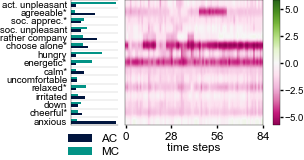

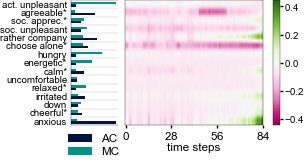

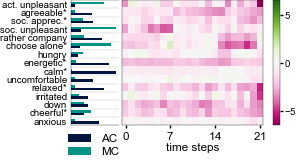

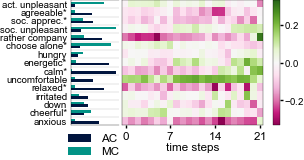

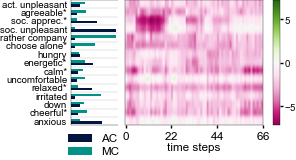

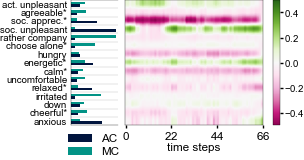

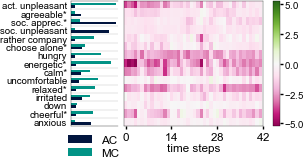

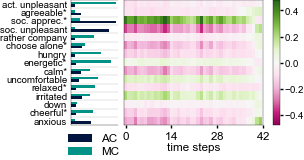

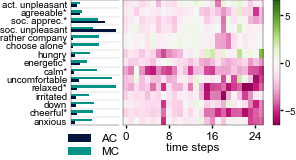

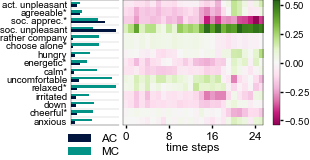

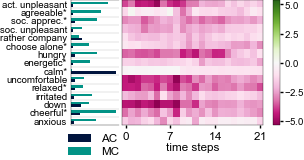

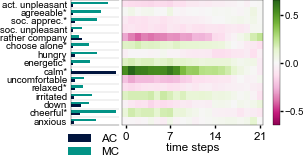

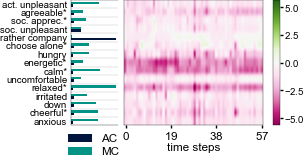

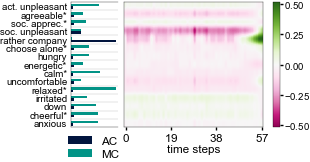

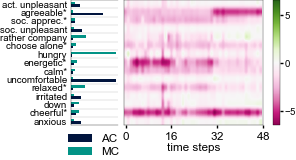

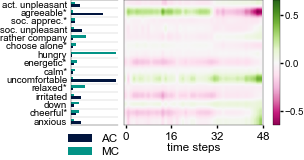

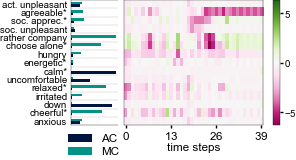

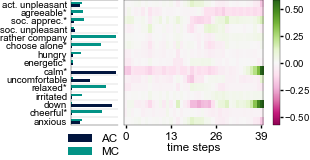

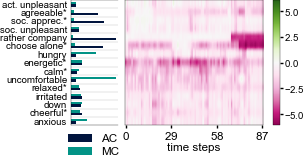

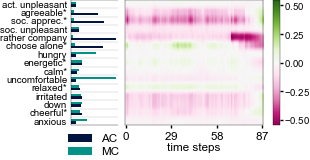

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from ctrl.discrete_optimal_control2 import LQR
from ctrl import utils
import custom_rcparams_paper as crc

data = utils.load_data(3)
N = len(data)
participants = range(N)
n_feat = len(data[0]['Xlabs'])

r_space = [0.1, 100]
C = np.eye(n_feat)
Q = np.eye(n_feat)
labels = data[0]['Xlabs']
ylabels = list(labels)
for j in participants:
    A = data[j]['A']
    # B = data[j]['C']
    B = np.eye(A.shape[0])
    R = np.eye(B.shape[1])
    X = data[j]['X']
    Yref = np.ones_like(X) * (-3)
    ac = LQR.average_ctrb(A, 15)
    ac /= ac.max()
    mc = LQR.modal_ctrb(A)
    mc /= mc.max()

    for r, title in zip(range(len(r_space)), ['Low ctrl constraint', 'High ctrl constraint']):
        U = LQR.tracking_optimal_control(A, B, C, Q, R*r_space[r], X, Yref)        

        with mpl.rc_context({'ytick.labelsize':'x-small', 'figure.constrained_layout.wspace':0}):
            fig, axes = plt.subplots(1, 2, figsize=(2.8,1.6), gridspec_kw={'width_ratios': (3, 10)}, sharey=True)
            # plt.suptitle(f'Participant {j+1}')
            utils.bars(np.vstack((ac, mc)), horizontal=True, width=0.6, ax=axes[0], color=[crc.colors.ac, crc.colors.mc])
            axes[0].set_xlim([-0, 1.05])
            axes[0].set_xticks([])
            axes[0].legend(['AC', 'MC'], loc='upper left', bbox_to_anchor=[-0.25,0])
            # utils.colorplot_trajectory((B @ U.T).T, ylabels, rf'{title} ($\rho={r_space[r]}$)', ax=axes[1], cmap='PiYG',
            #                             vmin=-np.abs(U).max(), vmax=np.abs(U).max())            
            utils.colorplot_trajectory((B @ U.T).T, ylabels, '', ax=axes[1], cmap='PiYG',
                                        vmin=-np.abs(U).max(), vmax=np.abs(U).max())
            axes[0].minorticks_on()
            axes[1].tick_params(which='minor', left=False)
            axes[0].set_yticks(np.arange(0.5, n_feat-0.5, 1), minor=True)
            axes[0].set_xticks([], minor=True)
            axes[0].grid(visible=True, which='minor')
            axes[0].tick_params(which='minor', left=False, bottom=False)
            axes[0].tick_params(which='major', left=False)
            axes[0].spines['right'].set_visible(False)
            fig.savefig(f'figures/paper/figure4F_participant{j+1}_rho{r_space[r]}.png')
            fig.savefig(f'figures/paper/figure4F_participant{j+1}_rho{r_space[r]}.svg')    


Figure 4C Alternative

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from ctrl.discrete_optimal_control2 import LQR
from ctrl import utils
from custom_rcparams import colors

data = utils.load_data(3)
N = len(data)
n_feat = len(data[0]['Xlabs'])

r_space = [0.1, 100]
C = np.eye(n_feat)
Q = np.eye(n_feat)
labels = data[0]['Xlabs']
ylabels = list(labels)

for j in [2,9]:

    A = data[j]['A']
    # B = data[j]['C']
    B = np.eye(A.shape[0])
    R = np.eye(B.shape[1])
    X = data[j]['X']
    Yref = np.ones_like(X) * (-3)
    ac = LQR.average_ctrb(A)
    ac /= ac.max()
    mc = LQR.modal_ctrb(A)
    mc /= mc.max()

    for r, title in zip(range(len(r_space)), ['Low ctrl constraint', 'High ctrl constraint']):
        U = LQR.tracking_optimal_control(A, B, C, Q, R*r_space[r], X, Yref)

        fig, axes = plt.subplots(1, 2, figsize=(6.5,4.5), gridspec_kw={'width_ratios': (3, 10)}, sharey=True)
        plt.suptitle(f'Participant {j+1}')
        utils.bars(np.vstack((ac, mc)), horizontal=True, width=0.6, ax=axes[0], color=[colors.ac, colors.mc])
        axes[0].set_xlim([-0, 1.05])
        axes[0].set_xticks([])
        axes[0].legend(['AC', 'MC'], loc='upper left', bbox_to_anchor=[-0.25,0])
        utils.colorplot_trajectory((B @ U.T).T**2, ylabels, rf'{title} ($\rho={r_space[r]}$)', ax=axes[1], cmap='OrRd')
        axes[0].minorticks_on()
        axes[1].tick_params(which='minor', left=False)
        axes[0].set_yticks(np.arange(0.5, n_feat-0.5, 1), minor=True)
        axes[0].set_xticks([], minor=True)
        axes[0].grid(visible=True, which='minor')
        axes[0].tick_params(which='minor', left=False, bottom=False)
        axes[0].tick_params(which='major', left=False)
        axes[0].spines['right'].set_visible(False)
        fig.tight_layout()
        fig.subplots_adjust(wspace=0)
        fig.savefig(f'figures/paper/exampleE_participant{j+1}_rho{r_space[r]}.png')
        fig.savefig(f'figures/paper/exampleE_participant{j+1}_rho{r_space[r]}.svg')
        
